<a href="https://colab.research.google.com/github/wandb/examples/blob/master/catalyst/Catalyst_X_Wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--- @wandbcode{} -->

## Rapid Experimentation with Catalyst and W&B
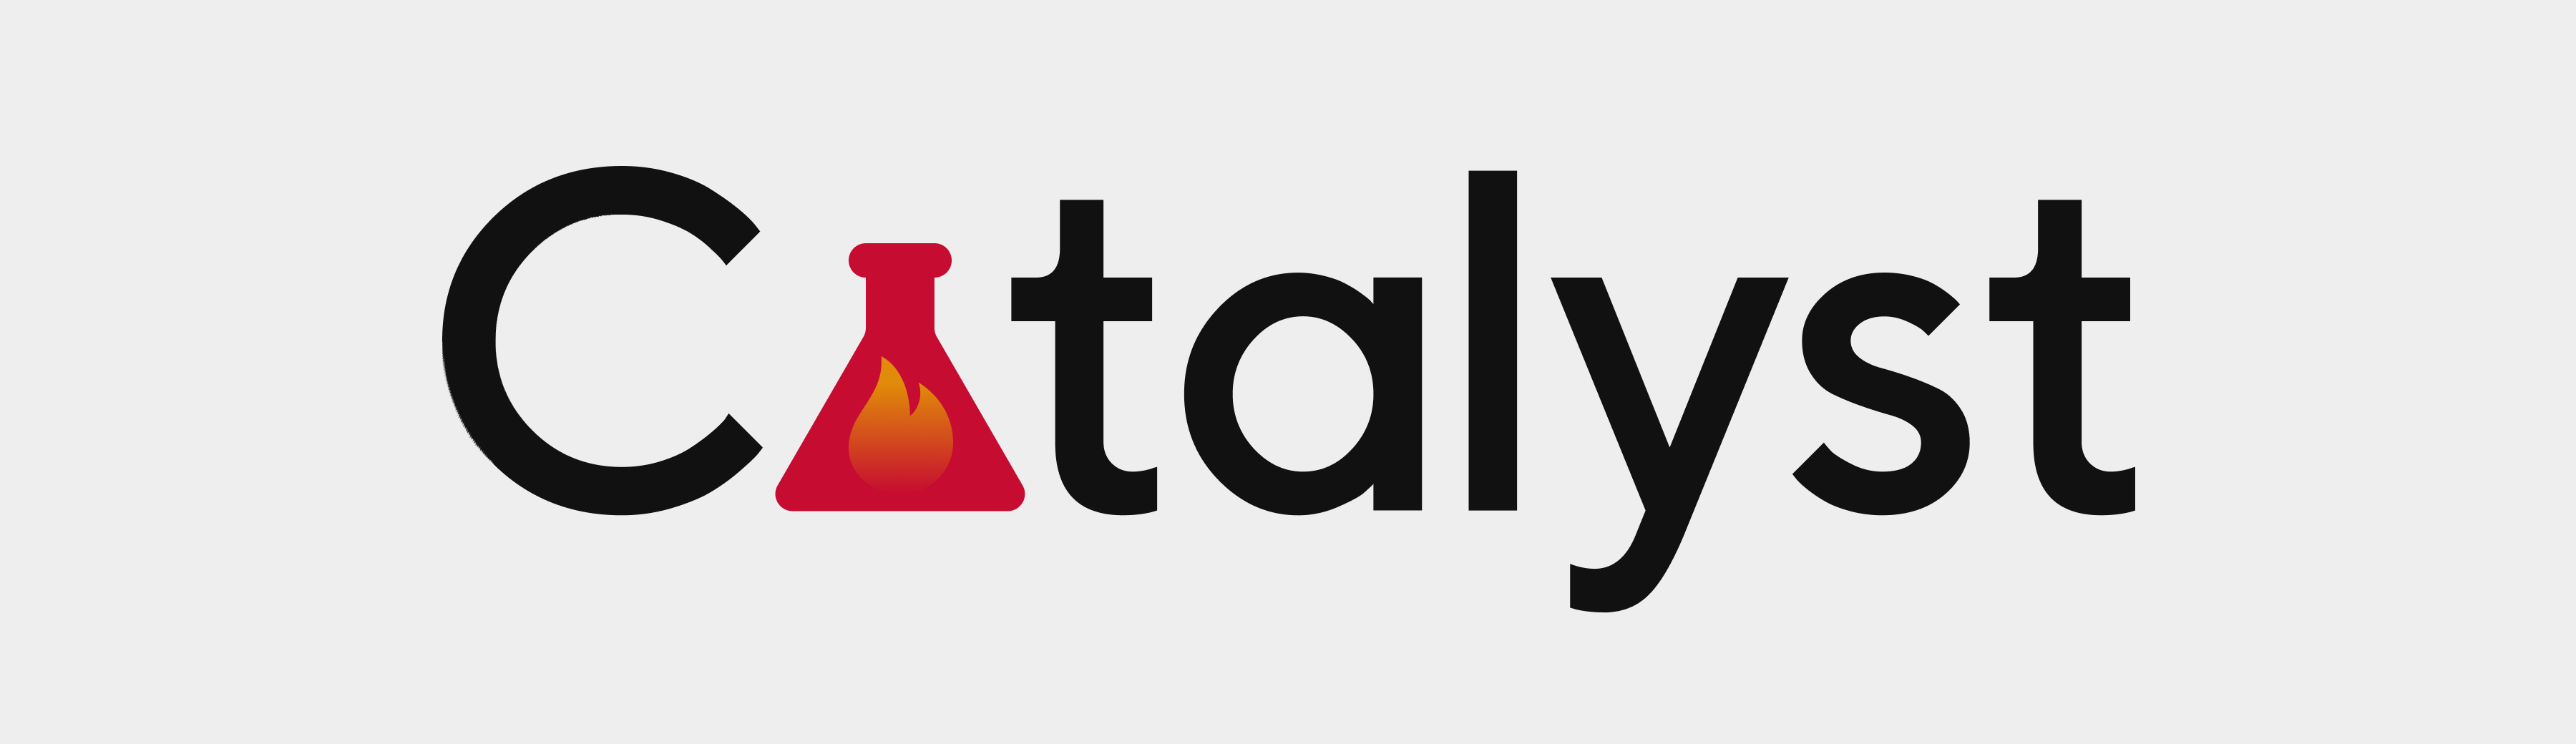
Catalyst is a PyTorch framework for deep learning and R&D. It focuses on reproducibility, rapid experimentation, and codebase reuse so you can create something new rather than write yet another train loop. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1woAYD9hot7mbknGhbxtix7x7u1fvIZJx?usp=sharing)

In [ ]:
!pip install -q catalyst==21.10
!pip install -q catalyst[ml]==21.10
!pip install -q catalyst[cv]==21.10
!pip install -q wandb 
!pip install -q opencv-python-headless==4.1.2.30

Restart run time after the above setup steps!

In [ ]:
import os
from tempfile import TemporaryDirectory

from pytest import mark
from torch import nn, optim
from torch.utils.data import DataLoader

from catalyst import dl, utils
from catalyst.contrib.datasets import MNIST
from catalyst.data.transforms import ToTensor
from catalyst.settings import IS_CUDA_AVAILABLE, NUM_CUDA_DEVICES, SETTINGS

## Example - MNIST Classification

In [ ]:
class CustomRunner(dl.IRunner):
    def __init__(self, logdir, device, engine):
        super().__init__()
        self._logdir = logdir
        self._device = device
        self._engine = engine
        self._name = "mnist"

    def get_engine(self):
        return self._engine or dl.DeviceEngine(self._device)

    def get_loggers(self):
        loggers = {}
        if SETTINGS.wandb_required:
            loggers["wandb"] = dl.WandbLogger(project="catalyst_wandb", name=self._name)
        return loggers

    @property
    def stages(self):
        return ["train_freezed", "train_unfreezed"]

    def get_stage_len(self, stage: str) -> int:
        return 1

    def get_loaders(self, stage: str):
        loaders = {
            "train": DataLoader(
                MNIST(os.getcwd(), train=False, download=True, transform=ToTensor()),
                batch_size=32,
            ),
            "valid": DataLoader(
                MNIST(os.getcwd(), train=False, download=True, transform=ToTensor()),
                batch_size=32,
            ),
        }
        return loaders

    def get_model(self, stage: str):
        model = (
            utils.get_nn_from_ddp_module(self.model)
            if self.model is not None
            else nn.Sequential(nn.Flatten(), nn.Linear(784, 128), nn.ReLU(), nn.Linear(128, 10))
        )
        if stage == "train_freezed":
            # freeze layer
            utils.set_requires_grad(model[1], False)
        else:
            utils.set_requires_grad(model, True)
        return model

    def get_criterion(self, stage: str):
        return nn.CrossEntropyLoss()

    def get_optimizer(self, stage: str, model):
        if stage == "train_freezed":
            return optim.Adam(model.parameters(), lr=1e-3)
        else:
            return optim.SGD(model.parameters(), lr=1e-1)

    def get_scheduler(self, stage: str, optimizer):
        return None

    def get_callbacks(self, stage: str):
        callbacks = {
            "criterion": dl.CriterionCallback(
                metric_key="loss", input_key="logits", target_key="targets"
            ),
            "optimizer": dl.OptimizerCallback(
                metric_key="loss",
                grad_clip_fn=nn.utils.clip_grad_norm_,
                grad_clip_params={"max_norm": 1.0},
            ),
            # "scheduler": dl.SchedulerCallback(loader_key="valid", metric_key="loss"),
            "accuracy": dl.AccuracyCallback(
                input_key="logits", target_key="targets", topk_args=(1, 3, 5)
            ),
            "classification": dl.PrecisionRecallF1SupportCallback(
                input_key="logits", target_key="targets", num_classes=10
            ),
            "checkpoint": dl.CheckpointCallback(
                self._logdir, loader_key="valid", metric_key="loss", minimize=True, save_n_best=3
            ),
        }
        if SETTINGS.ml_required:
            callbacks["confusion_matrix"] = dl.ConfusionMatrixCallback(
                input_key="logits", target_key="targets", num_classes=10
            )
        return callbacks

    def handle_batch(self, batch):
        x, y = batch
        logits = self.model(x)

        self.batch = {
            "features": x,
            "targets": y,
            "logits": logits,
        }

## W&B integration
Catalyst comes with `WandbLogger` based on its logger API which can be used to stream your experiment metrics, media and experiment configurations.
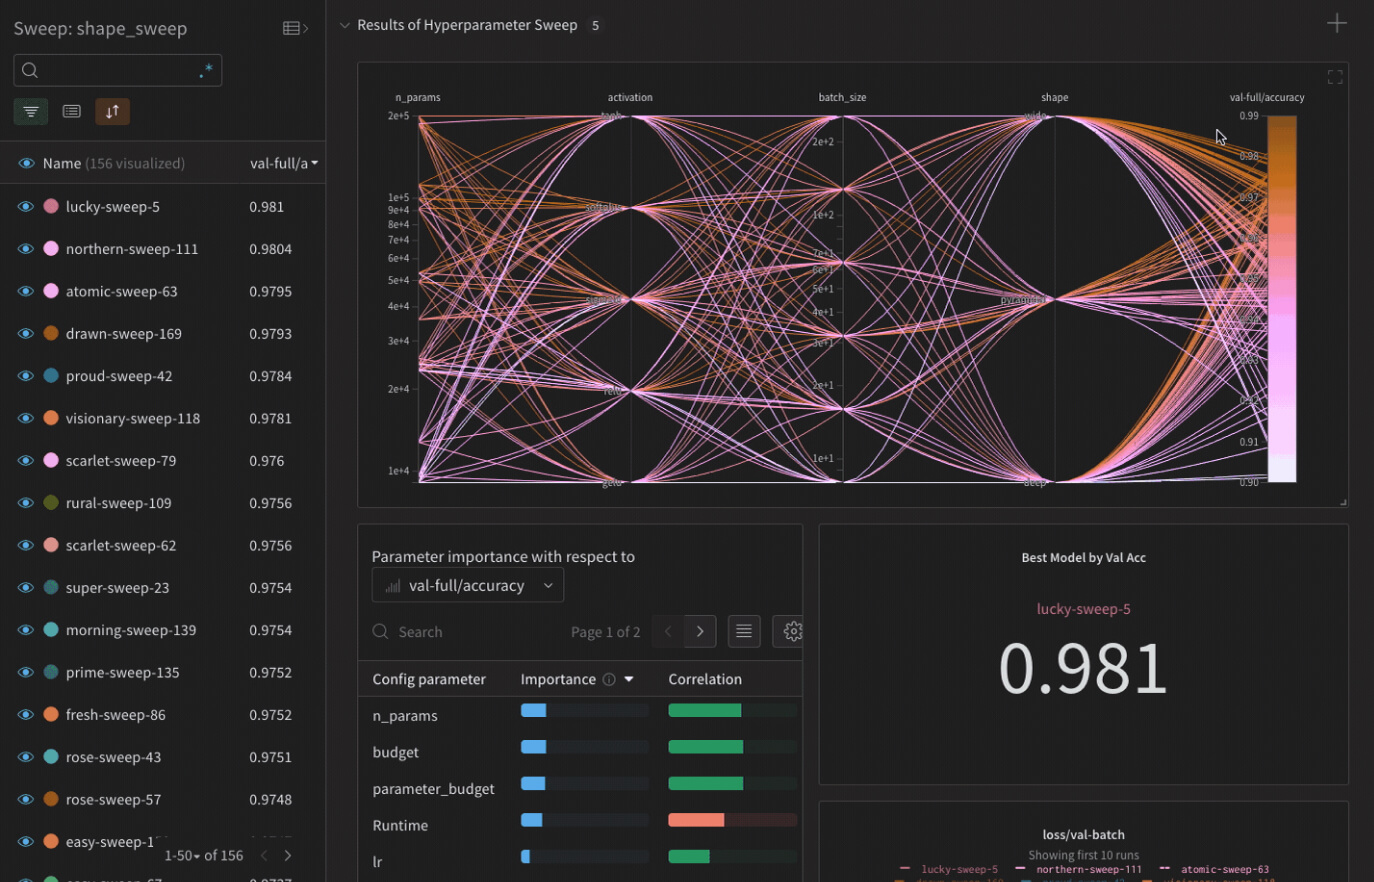

In [ ]:
def train_experiment(device, engine=None):
    with TemporaryDirectory() as logdir:
        runner = CustomRunner(logdir, device, engine)
        runner.run()


In [ ]:
train_experiment("cuda:0") # Train on GPU